### Sentiment Analysis

Analyzing the Amazon Alexa dataset and building classification models to predict if the sentiment is positive or negative.

### Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score, recall_score, precision_score,f1_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to C:\Users\SAI RAM
[nltk_data]     GANDHI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Exploratory Data Analysis

In [2]:
#Load the data

data = pd.read_csv("amazon_alexa.tsv", delimiter = '\t')

print(f"Dataset shape : {data.shape}")

Dataset shape : (3150, 5)


In [3]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
#Column names

print(f"Feature names : {data.columns.values}")

Feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [5]:
#Check for null values

data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

There is one record with no 'verified_reviews' (null value)

In [6]:
#Getting the record where 'verified_reviews' is null 

data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [7]:
#We will drop the null record

data.dropna(inplace=True)

In [8]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (3149, 5)


In [9]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['verified_reviews'].apply(len)

In [10]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


The 'length' column is new generated column - stores the length of 'verified_reviews' for that record.

Datatypes of the features

In [11]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

* rating, feedback and length are integer values <br>
* date, variation and verified_reviews are string values

### Analyzing 'rating' column

This column refers to the rating of the variation given by the user

In [12]:
#Distinct values of 'rating' and its count  

print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


Let's plot the above values in a bar graph

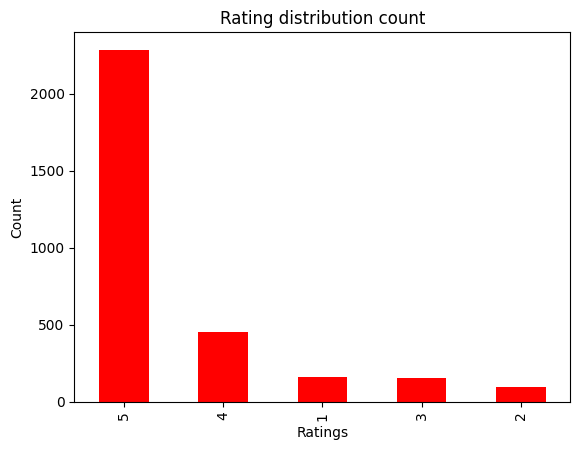

In [13]:
#Bar plot to visualize the total counts of each rating

data['rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

### Analyzing 'feedback' column

This column refers to the feedback of the verified review

In [14]:
#Distinct values of 'feedback' and its count 

print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1    2893
0     256
Name: count, dtype: int64


In [15]:
#Extracting the 'verified_reviews' value for one record with feedback = 0

review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [16]:
#Extracting the 'verified_reviews' value for one record with feedback = 1

review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


From the above 2 examples we can see that feedback **0 is negative review** and **1 is positive review**

Let's plot the feedback value count in a bar graph

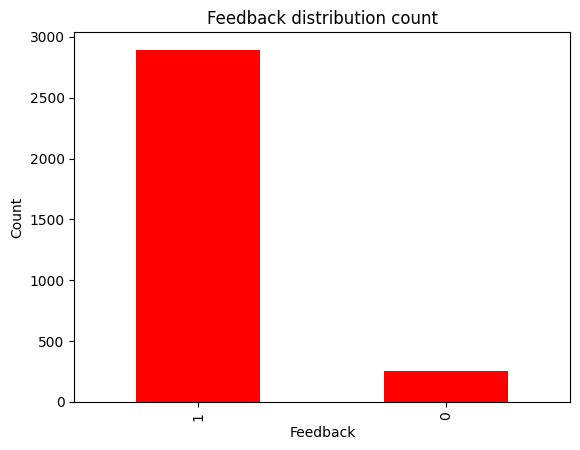

In [17]:
#Bar graph to visualize the total counts of each feedback

data['feedback'].value_counts().plot.bar(color = 'red')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

Let's see the 'rating' values for different values of 'feedback'

In [18]:
#Feedback = 0
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [19]:
#Feedback = 1
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

##### If rating of a review is 1 or 2 then the feedback is 0 (negative) and if the rating is 3, 4 or 5 then the feedback is 1 (positive).

### Analyzing 'verified_reviews' column

This column contains the textual review given by the user for the product.

In [20]:
data['length'].describe()

count    3149.000000
mean      132.090187
std       182.114569
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: length, dtype: float64

Length analysis when feedback is 0 (negative)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

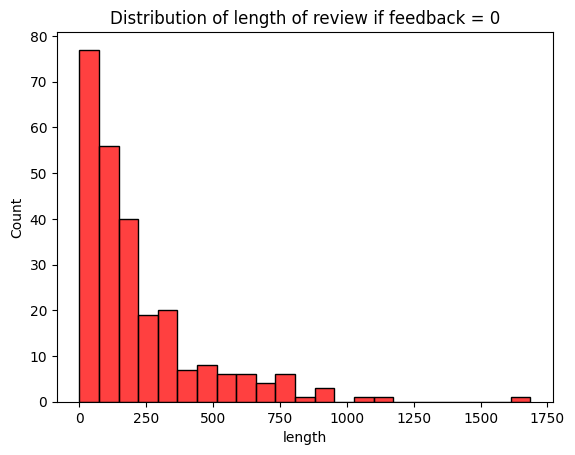

In [21]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

Length analysis when feedback is 1 (positive)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

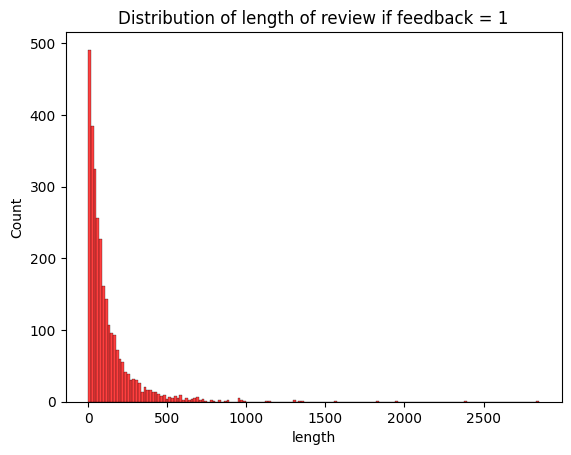

In [22]:
sns.histplot(data[data['feedback']==1]['length'],color='red').set(title='Distribution of length of review if feedback = 1')

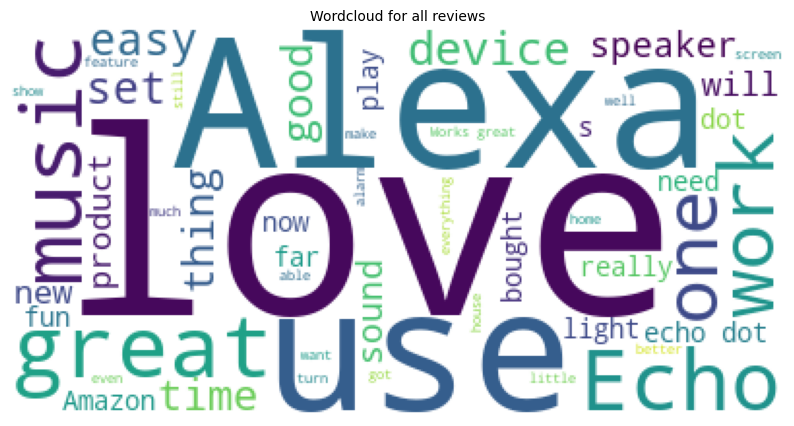

In [23]:
# Combine all reviews for word cloud
reviews = " ".join([review for review in data['verified_reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [24]:
# Combine all reviews for each feedback category for word cloud
pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])

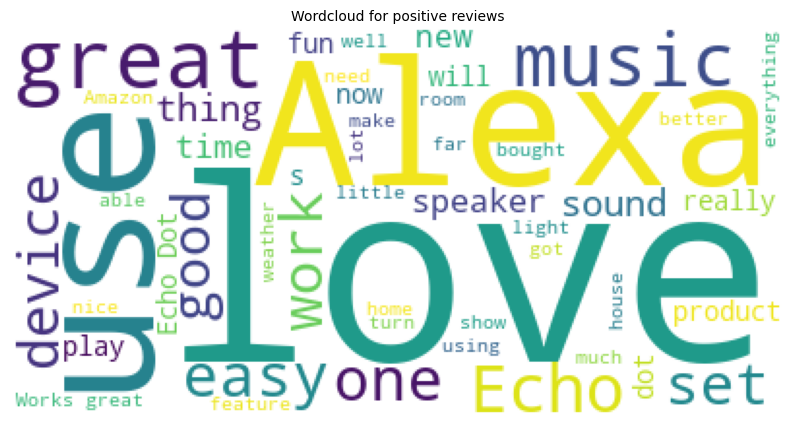

In [25]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(pos_reviews))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

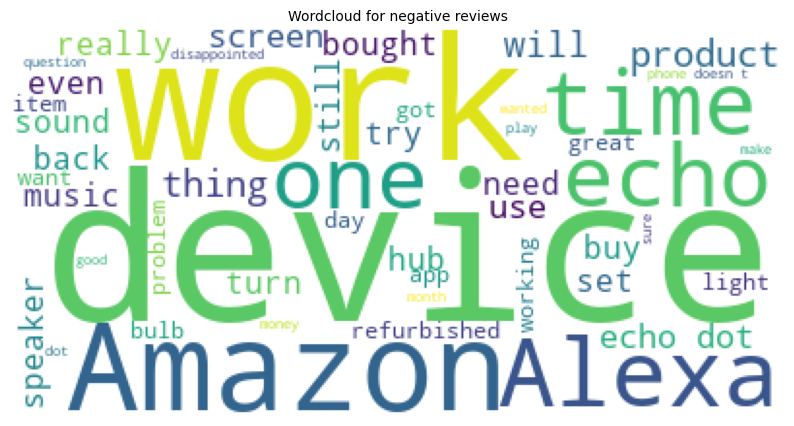

In [26]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(neg_reviews))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

# Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [27]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

In [28]:
len(corpus)

3149

Using Count Vectorizer to create bag of words

In [29]:
cv = CountVectorizer()

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [30]:
X.shape

(3149, 2765)

In [31]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3149, 2765)
y shape: (3149,)


In [32]:
#Saving the Count Vectorizer
pickle.dump(cv, open('countVectorizer.pkl', 'wb'))

In [33]:
#Upsampling the data

smote = SMOTE(random_state=42)
X_upsampled, y_upsampled = smote.fit_resample(X,y)

In [34]:
print(f"X_upsampled: {X_upsampled.shape}")
print(f"y_upsampled: {y_upsampled.shape}")

X_upsampled: (5786, 2765)
y_upsampled: (5786,)


In [35]:
X = X_upsampled
y = y_upsampled

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (4628, 2765)
y train: (4628,)
X test: (1158, 2765)
y test: (1158,)


We'll scale X_train and X_test so that all values are between 0 and 1.

In [38]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [39]:
#Saving the scaler model
pickle.dump(scaler, open('scaler.pkl', 'wb'))

#### Decision Tree Classifier

In [40]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [41]:
y_preds = model_dt.predict(X_test_scl)

In [42]:
# Function to calculate evaluation metrics
def calculate_metrics(y_true, y_pred):
    # Generate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()    
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)    
    # Sensitivity (Recall): TP / (TP + FN)
    sensitivity = recall_score(y_true, y_pred)    
    # Specificity: TN / (TN + FP)
    specificity = tn / (tn + fp)  
    #precision = TP/(TP+FP)
    precision = tp/(tp+fp)
    # f1 score : 2*precison*recall/(precision+recall)
    f1 = f1_score(y_test, y_pred)
    return accuracy, sensitivity, specificity,precision,f1

In [43]:
# Calculate metrics
accuracy, sensitivity, specificity,precision,f1 = calculate_metrics(y_test, y_preds)
print(f"Accuracy: {accuracy:.2f}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.94
Sensitivity: 0.92
Specificity: 0.96
Precision: 0.96
F1 Score: 0.94


In [45]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[545  22]
 [ 46 545]]


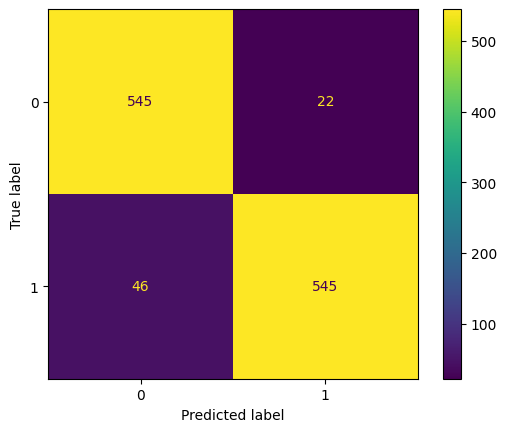

In [46]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

In [47]:
#Saving the Decision Tree classifier
pickle.dump(model_dt, open('model_dt.pkl', 'wb'))

#### Random Forest

In [48]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [49]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [50]:
# Function to calculate evaluation metrics
def calculate_metrics(y_true, y_pred):
    # Generate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()    
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)    
    # Sensitivity (Recall): TP / (TP + FN)
    sensitivity = recall_score(y_true, y_pred)    
    # Specificity: TN / (TN + FP)
    specificity = tn / (tn + fp)  
    #precision = TP/(TP+FP)
    precision = tp/(tp+fp)
    # f1 score : 2*precison*recall/(precision+recall)
    f1 = f1_score(y_test, y_pred)
    return accuracy, sensitivity, specificity,precision,f1

In [51]:
# Calculate metrics
accuracy, sensitivity, specificity,precision,f1 = calculate_metrics(y_test, y_preds)
print(f"Accuracy: {accuracy:.2f}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.95
Sensitivity: 0.95
Specificity: 0.96
Precision: 0.96
F1 Score: 0.95


In [53]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[542  25]
 [ 31 560]]


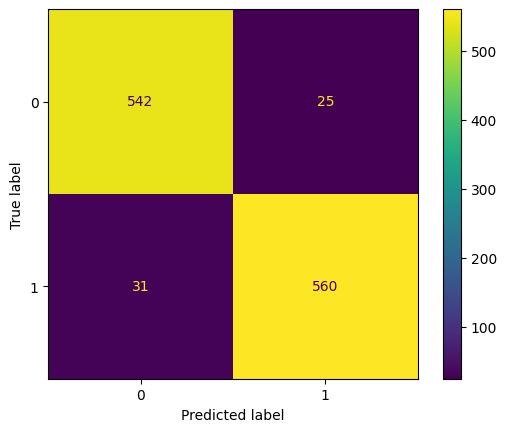

In [54]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [55]:
#Saving the Random Forest classifier
pickle.dump(model_rf, open('model_rf.pkl', 'wb'))

In [56]:
def single_prediction(predictor, scaler, cv, text_input):
    corpus = []
    stemmer = PorterStemmer()
    review = re.sub("[^a-zA-Z]", " ", text_input)
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
    review = " ".join(review)
    corpus.append(review)
    X_prediction = cv.transform(corpus).toarray()
    X_prediction_scl = scaler.transform(X_prediction)
    y_predictions = predictor.predict(X_prediction_scl)
    return "Positive" if y_predictions == 1 else "Negative"

In [57]:
predictor = pickle.load(open("model_dt.pkl", "rb"))
scaler = pickle.load(open("scaler.pkl", "rb"))
cv = pickle.load(open("countVectorizer.pkl", "rb"))

In [58]:
aspects = ["quality", "price", "performance", "service", "design"]

In [59]:
def split_sentence_on_aspects(sentence, aspects):
    # Create a regex pattern to match aspect words as separate words (case insensitive)
    pattern = r'\b(' + '|'.join(aspects) + r')\b'
    
    # Find all occurrences of aspect words and their positions
    matches = [(match.group(), match.start()) for match in re.finditer(pattern, sentence, re.IGNORECASE)]
    
    # If no aspect words found, return the whole sentence as a single entry
    if not matches:
        return [["general", sentence]]
    
    # Store result in list-of-lists format with aspect and corresponding sentence part
    result = []
    start = 0
    for i, (word, pos) in enumerate(matches):
        # Find the end of the current aspect's sentence part
        end = matches[i + 1][1] if i + 1 < len(matches) else len(sentence)
        
        # Capture the part from the current aspect position to the next
        part = sentence[pos:end].strip()
        result.append([word, part])
        
        # Update start for the next loop iteration
        start = end
    
    return result

In [60]:
# Example
sentence = "Nice Product"
result = split_sentence_on_aspects(sentence, aspects)

In [61]:
for aspect, sentence_part in result:
    print(f"Aspect : {aspect}")
    print(f"Sentiment : {single_prediction(predictor, scaler, cv, sentence_part)}")
    print()


Aspect : general
Sentiment : Positive



In [62]:
print(f"Sentiment : {single_prediction(predictor, scaler, cv, sentence)}")

Sentiment : Positive


In [63]:
# Example
sentence = "Bad Product"
result = split_sentence_on_aspects(sentence, aspects)

In [64]:
for aspect, sentence_part in result:
    print(f"Aspect : {aspect}")
    print(f"Sentiment : {single_prediction(predictor, scaler, cv, sentence_part)}")
    print()


Aspect : general
Sentiment : Negative



In [65]:
print(f"Sentiment : {single_prediction(predictor, scaler, cv, sentence)}")

Sentiment : Negative


In [66]:
# Example
sentence = "quality is really nice and the performance is excellent but the price is too high"
result = split_sentence_on_aspects(sentence, aspects)

In [67]:
for aspect, sentence_part in result:
    print(f"Aspect : {aspect}")
    print(f"Sentiment : {single_prediction(predictor, scaler, cv, sentence_part)}")
    print()


Aspect : quality
Sentiment : Positive

Aspect : performance
Sentiment : Positive

Aspect : price
Sentiment : Negative



In [68]:
print(f"Sentiment : {single_prediction(predictor, scaler, cv, sentence)}")

Sentiment : Positive
